# Introduction

Several months ago, we were presented with a scenario for how artificial general intelligence (AGI) may be achieved in the near future. We found the approach surprising, so we attempted to produce a rough model to investigate its feasibility. This document presents the model and its conclusions.

The usual cliches about the folly of trying to predict the future go without saying and this shouldn't be treated as a rigorous estimate, but hopefully it can give a loose, rough sense of some of the relevant quantities involved. The notebook and the data used for it can be found in the Median Group [numbers GitHub repo](https://github.com/Median-Group/numbers) if the reader is interested in using different quantities or changing the structure of the model. If the reader is interested in a more general approach based on the rate of theoretical progress, see our [Insights](http://mediangroup.org/insights) model.


To briefly explain the proposal: 

- Create a simulated world somewhat similar to our world (i.e, containing space-time, material, programming, multiple agents, etc).
- Simulate many agents, each with an amount of computing power equal to the human brain. These agents interact in a manner similar to that of evolution; the most fit survive and reproduce.
- At the end, a collection of the most fit individuals are given data about our world and asked to solve problems for rewards (this is really not a good way to do AI alignment but can plausibly produce misaligned AGI).


This does not take into account:

- serial vs. parallel training
- FLOPS vs. other considerations (memory, TEPS, latency)
- breakdown of exponential price performance improvement
- costs associated with things other than a subset of the training hardware (there are many others)
- time required to develop software
- difficulty of creating and running a simulated world
- paradigm shifts in AI (e.g. no longer doing reinforcement learning) that would make this scenario irrelevant
- whether "difficulty ratio" relative to Go makes sense (it probably doesn't except in the loosest sense)

## A Note about Uncertainty and Distributions
Much of the challenge associated with modelling this scenario derives from the difficulty of estimating (or even bounding) many of the parameters. When possible, we use distributions or values corresponding to commonly accepted quantities. In the cases where there are no such quantities, we attempt to construct reasonable distributions with very wide bounds to reflect the uncertainty.

If reasonable confidence bounds can be established (these terms are meant loosely), we will use a generally [log-uniform](http://ecolego.facilia.se/ecolego/show/Log-Uniform%20Distribution) distribution.

In [51]:
%matplotlib inline

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import warnings

# Suppress Pandas plotting error
warnings.filterwarnings("ignore")

# plot aesthetics
sns.set()

# number of samples for Monte Carlo simulation
n = 50000

# summary table of distribution
def summary(data, unit=''):
    """
    Returns Pandas dataframe summarizing distribution of data with percentiles
    Mostly for convenience
    
    Paramaeters
    -----------
    data : array_like
        Input array or array-like object
    unit : str
        Units associated with data
    
    Returns
    -------
    out : pandas.DataFrame
    """
    
    percentiles = [1, 5, 25, 50, 75, 95, 99]
    values = np.percentile(data, percentiles)
    df = pd.DataFrame(data={"Percentile": percentiles, unit: values})
    # df = df.concat(["Mean", np.mean(data)])
    return df[["Percentile", unit]]

# log-uniform distribution
def loguniform(low=0, high=1, size=None):
    """
    Returns loguniform distribution bounded by low and high orders of magnitude.
    
    Parameters
    ----------
    low : float, optional
        Order-of-magnitude lower boundary of the output interval.
        All values generated will be greater than or equal to low.
        The default value is 0.
    high : float, optional
        Order-of-magnitude upper boundary of the output interval.
        All values generated will be less than high.
        The default value is 1.
    size : int or tuple of ints, optional
        Output shape
    
    Returns
    -------
    out : ndarray or scalar
         samples from the loguniform distribution
    """
    return 10**np.random.uniform(low, high, size)

## Computational Performance of the Brain
The computational performance of the brain will be estimated in operations per second. [This is a convenient but incredibly flawed approach](http://mediangroup.org/brain1.html). [Sandberg and Bostrom (2009)](https://www.fhi.ox.ac.uk/brain-emulation-roadmap-report.pdf) contains a summary of estimates from the literature:

- Tuszynski (2006): $10^{28}$ FLOPS
- Kurzweil (1999): $2\times10^{16}$ FLOPS
- Thagard (2002): $10^{23}$ FLOPS
- Bostrom (1998): $10^{17}$ operations per second
- Merkle (1989): $2\times10^{15}$ operations per second
- Merkle (1989): $10^{13}$ operations per second
- Dix (2005): $10^{16}$ synaptic operations per second
- Seitz (2007): $2\times10^{16}$ synaptic operations per second *(note: the Bostrom paper incorrectly reports this as $2\times 10^{12}$, see the [original](http://hiqnews.megafoundation.org/The_Great_Gray_Ravelled_Knot.htm))*
- Malickas (1996): $10^{16}$ synaptic operations per second

[Martins et al. 2012](https://repositorium.sdum.uminho.pt/bitstream/1822/20756/1/NanoroboticBrainMonitoring2012_%20draft%20with%20page%20numbers.pdf) offers a few more estimates:

- Moravec (1998): $10^{14}$ FLOPS
- Sarpeshka (1998): $3.6\times10^{15}$ synaptic operations per second

The estimates from Tuszynski (2006) and Thagard (2002) are derived from speculations about quantum computation occurring in the brain. As this is usually regarded as biologically implausible, they will be excluded from the data set. 

Note: the smaller estimate by Merkle (1989) seems to over-estimate both the capacitance of axons and how completely that capacitance is discharged when conducting an action potential, but it will be included anyway.

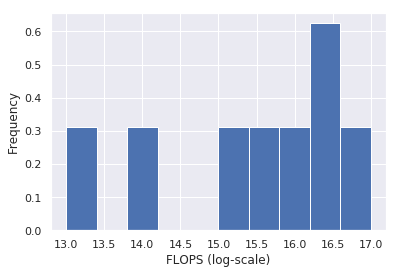

In [33]:
brain_flops = np.log10([2e16, 1e17, 1e13, 2e15, 1e16, 2e16, 1e14, 3.6e15])
plt.hist(brain_flops, density=True);
plt.xlabel("FLOPS (log-scale)");
plt.ylabel("Frequency");

These estimates are typically generated by multiplying uncertain quantities, so we expect the resulting distribution to resemble a mixture of Gaussians in log-space.  We will use a kernel density estimator to produce a distribution from the estimates, with the bandwidth hyperparameter tuned empirically using cross-validation.

,Percentile,Operations per second
0,1,2.926178e+11
1,5,3.113016e+12
2,25,2.307572e+14
3,50,4.015672e+15
4,75,3.945256e+16
5,95,7.642728e+17
6,99,5.129267e+18


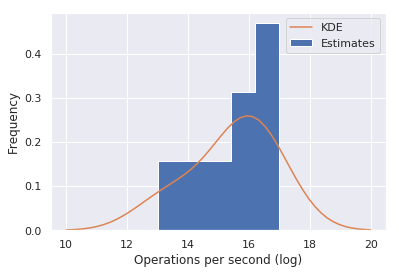

In [34]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

x = np.linspace(10, 20).reshape(-1, 1)
brain_flops = brain_flops.reshape(-1, 1)
bandwidths = 10 ** np.linspace(-1, 1)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(brain_flops);
bw = grid.best_params_['bandwidth']
kde = KernelDensity(bandwidth=bw, kernel='gaussian')
kde.fit(brain_flops)
brain_compute = 10**kde.sample(n)[:,0]

plt.hist(brain_flops,
         bins=5,
         histtype='stepfilled',
         density=True,
         label="Estimates");
plt.plot(x, np.exp(kde.score_samples(x)), label="KDE");
plt.xlabel("Operations per second (log)");
plt.ylabel("Frequency");
plt.legend()
summary(brain_compute, "Operations per second")

## Subjective-Lifespan of AI

How long does each AI have to live (in subjective time) in order to become generally competent enough to take significant strategic action in the world, and then actually take this action? This could be comparable to human lifetimes or substantially shorter. We will err towards the side of "substantially shorter".

,Percentile,Years
0,1,0.334516
1,5,0.417490
2,25,1.313593
3,50,5.474537
4,75,23.136432
5,95,74.352380
6,99,93.907044


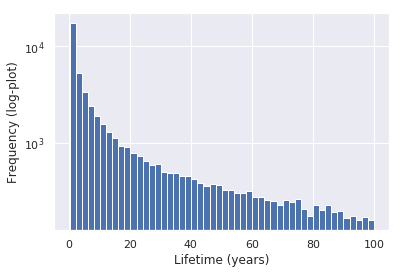

In [35]:
from scipy.stats import lognorm

# longevity in days
longevity = loguniform(high=2, low=-.5, size=n)

plt.hist(longevity, bins=50, log=True);
plt.xlabel('Lifetime (years)');
plt.ylabel('Frequency (log-plot)');
summary(longevity, 'Years')

# Comparisons to AlphaGo Zero

### AlphaGo Zero Training Time
This model uses DeepMind's [AlphaGo Zero](https://www.nature.com/articles/nature24270) as a benchmark, which beat the superhuman Go AI *AlphaGo Lee* 36 hours into its initial three-day training period. *AlphaGo Zero* played ~4.9 million games during this period, so *AlphaGo Zero* obtained superhuman performance after roughly 2.5 million games.

In [36]:
# number of games played by AlphaGo Zero
agz_games = 2.5e6

### Sample Efficiency of General Intelligence Compared to Go

A ratio of one would mean that, in the future, AI researchers discover an AI architecture that is as efficient ag learning general action in the world as AlphaZero is at learning Go. A ratio of _1000_ would mean it takes 1000 times as many lifetimes per unit of learning compared with AlphaZero. It is plausible that useful architectures could be learned from neuroscience, although this would require large advances in the neuroscience field (see [Could a Neuroscientist Understand a Microprocessor?
](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005268)). We can think of this as a *difficulty ratio*.

This parameter is essentially impossible to estimate in a principled way, so we'll be a bit sloppy. To begin thinking about this, consider that *AlphaGo Zero* takes as input a 19-by-19 Go board (and the previous 16 board states). Each square can take one of three states (black, white, or empty) and there can be at most $19 \times 19 \times 2 = 722$ moves in a game, so each game provides at most $722 \times \log_2(3^{19\times19})\approx4.1\times 10^5$ bits of information. By comparison, the human optic nerve carries $\sim6\times 10^6$ bits per second ([see Raichle (2010)](http://www.brainm.com/software/pubs/dg/Hubs-Networks/Raichle_M.E--TwoViewof%20Brain.pdf)), or $\sim5\times10^{11}$ bits in a 24-hour period. Natural imagery and Go boards are both highly compressible, but a difference of this size suggests that we should probably be very surprised if the difficulty ratio were small. 

It's hard to tell whether or not our particular distribution is reasonable, but it's worth noting that simple neural networks have been around a very long time. Estimates derived from molecular clock studies on homologous genes suggest that sponges, jellyfish, and cone jellies diverged in the [Mesoproterozoic](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1689654/) over one billion years ago. Quite a lot of computation can happen over long geological time scales.

,Percentile,Difficulty Ratio
0,1,2.054450e+05
1,5,4.017578e+06
2,25,1.029188e+13
3,50,1.008063e+21
4,75,1.171638e+29
5,95,2.907911e+35
6,99,5.188879e+36


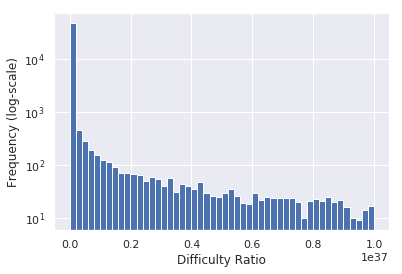

In [37]:
difficulty = loguniform(low=5, high=37, size=n)

plt.hist(difficulty, bins=50, log=True);
plt.xlabel('Difficulty Ratio');
plt.ylabel('Frequency (log-scale)');
summary(difficulty, 'Difficulty Ratio')

### Number of Hyperparameter Tuning Attempts
The AlphaGo Zero paper implies that a few different variations were trained in parallel during the initial training period, as is common practice for large deep learning projects. We should expect something similar in the scenario under consideration.

,Percentile,Tuning Attempts
0,1,1.033877
1,5,1.184992
2,25,2.368868
3,50,5.646292
4,75,13.410038
5,95,26.650292
6,99,30.568390


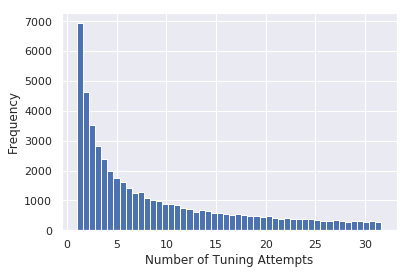

In [38]:
hyperparameters = loguniform(high=1.5, low=0, size=n)
plt.hist(hyperparameters, bins=50);
plt.xlabel("Number of Tuning Attempts");
plt.ylabel("Frequency");
summary(hyperparameters, 'Tuning Attempts')

## Future Hardware Improvements

### Trends in Computing Costs

While machine learning [ASICs](https://en.wikipedia.org/wiki/Application-specific_integrated_circuit) like TPUs are likely the future, the recent deep learning boom was powered by GPUs. Commonly mentioned figures for the price-performance generalization of Moore's Law suggest that price-performance doubles roughly every two years, but it's worth checking this figure against the observed price-performance changes in GPUs. The file `gpu.csv` contains the model name, launch date, single precision performance in GFLOPS, and release price in non-inflation-adjusted US dollars for 223 Nvidia and AMD GPUs (scraped from Wikipedia). The dataset covers almost two decades, so we will need to adjust the prices for inflation using the [Consumer Price Index](https://fred.stlouisfed.org/series/CPIAUCNS).

This notably neglects several important features:

- Much of the work that has been done in the past several years has been focused on reducing energy usage, which we don't attempt to capture with our focus on naive price-performance.
- The large proportion of the cost of running a data center today comes from electricity usage, not fixed capital like computing hardware.
- We are not considering the costs of other components, or attempting to project changes in their price performance.
- This does not consider the labor and engineering costs for such a project, which will almost certainly be very substantial.

However, it's an easy quantity to work with and provides some insight.

r = 0.716


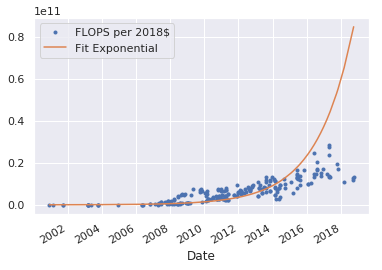

In [39]:
gpu = pd.read_csv("gpu.csv")
gpu['Date'] = pd.to_datetime(gpu['Date'], infer_datetime_format=True)

cpi = pd.read_csv("cpi.csv")
cpi['Date'] = pd.to_datetime(cpi['Date'], infer_datetime_format=True)
# Price multiplier to convert to 2018$
cpi['Price Multiplier'] = cpi['CPI'].iloc[-1] / cpi['CPI']

gpu = pd.merge_asof(
    gpu, cpi.filter(
        items=['Date', 'Price Multiplier']),
        on='Date',
        direction='nearest')

# Adjust prices for inflation
gpu['Adjusted Price (2018$)'] = gpu['Release Price (USD)'] * gpu['Price Multiplier']
# Inflation adjusted performance cost
gpu['FLOPS per 2018$'] = gpu['GFLOPS'] / gpu['Adjusted Price (2018$)'] * 10**9

# Convert dates to unix time
time, y = gpu['Date'].astype(np.int64) / 10**9, gpu['FLOPS per 2018$']

# Linear regression in log-space
#rate, constant = np.polyfit(time, np.log(y), 1, w=np.sqrt(y))
rate, constant = np.polyfit(time, np.log(y), 1)

gpu['Fit Exponential'] = pd.Series(np.exp(constant) * np.exp(rate*time))
gpu.plot(x='Date', y=['FLOPS per 2018$', 'Fit Exponential'], style=['.','-'])
#plt.savefig('gpu_full.png')
# Pearson's r (correlation coefficient)
print('r = {:.3f}'.format(gpu['FLOPS per 2018$'].corr(gpu['Fit Exponential'])))

This implies a doubling time of ~1.5 years.

In [40]:
doubling_time = 1 / (np.log2(np.e) * rate * 3600 * 24 * 365)
print("Doubling time: {:.2f} years".format(doubling_time))

Doubling time: 1.48 years


It should be noted that this is somewhat misleading because the price-performance curve isn't a clean exponential. An exponential curve appears linear in log-space, whereas the price-performance curve is sub-linear. Inspecting a log-plot suggests that price-performance has been in a distinctly slower growth regime since around 2012. 

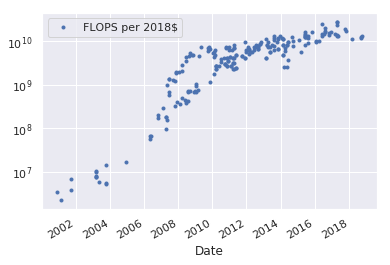

In [41]:
gpu.plot(x='Date', y='FLOPS per 2018$', style='.', logy=True);
#plt.savefig('gpu_log.png')

Fitting a curve to data from 2012 onward yields a doubling time of ~3.9 years.

r = 0.673
Doubling time: 3.93 years


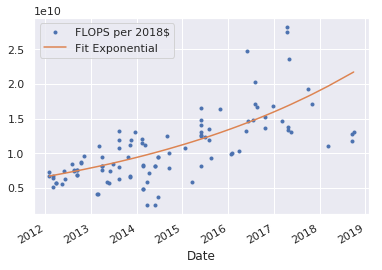

In [42]:
gpu = gpu[gpu['Date'] > pd.Timestamp('2012-01-01')]

# Convert dates to unix time
time, y = gpu['Date'].astype(np.int64) / 10**9, gpu['FLOPS per 2018$']

# Linear regression in log-space
rate, constant = np.polyfit(time, np.log(y), 1, w=np.sqrt(y))
gpu['Fit Exponential'] = pd.Series(np.exp(constant) * np.exp(rate*time))
# Pearson's r (correlation coefficient)
gpu.plot(x='Date', y=['FLOPS per 2018$', 'Fit Exponential'], style=['.','-'])
#plt.savefig('gpu_recent.png')
print('r = {:.3f}'.format(gpu['FLOPS per 2018$'].corr(gpu['Fit Exponential'])))
doubling_time = 1 / (np.log2(np.e) * rate * 3600 * 24 * 365)
print("Doubling time: {:.2f} years".format(doubling_time))

It is unclear how long even this reduced rate of growth can continue, and these improvements are expected to break down in the coming decades, with more than an additional 10-12 doublings being very unlikely within the current paradigm. The question of whether and how the trend will continue, perhaps through breakthroughs in [spintronics](https://en.wikipedia.org/wiki/Spintronics) or further improvements in [3D integrated circuits](https://en.wikipedia.org/wiki/Three-dimensional_integrated_circuit), is beyond the scope of this document.

### Architecture-Specific Improvements
So far, TPUs have been one generation behind the cutting-edge of semiconductor fabrication. Private communication with experts in the field suggests that a further one to two orders of magnitude of improvement in price-performance from technological progress and economies of scale is likely, with more not being out of the question.

,Percentile,Factor of Improvement
0,1,10.364245
1,5,11.898779
2,25,23.586700
3,50,55.881355
4,75,132.640638
5,95,264.910053
6,99,304.889214


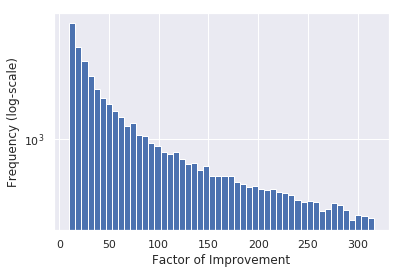

In [43]:
tpu_improvement = loguniform(low=1, high=2.5, size=n)
plt.hist(tpu_improvement, bins=50, log=True);
plt.xlabel("Factor of Improvement");
plt.ylabel("Frequency (log-scale)");
summary(tpu_improvement, 'Factor of Improvement')

## Computational Requirements

The estimated computational requirements are summarized below.

,Percentile,Operations
0,1,1.199615e+32
1,5,4.659938e+34
2,25,1.806512e+41
3,50,1.754430e+49
4,75,2.146480e+57
5,95,9.705500e+63
6,99,2.164436e+66


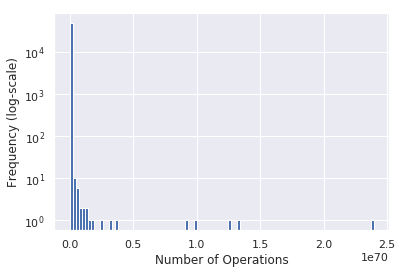

In [44]:
# Number of arithmetic operations to simulate a lifetime
lifetime_compute = brain_compute * longevity * 3600 * 24
# Number of simulated lifetimes needed to train an AGI
lifetimes = hyperparameters * difficulty * agz_games
# Number of arithmetic operations to train an AGI
agi_compute = lifetime_compute * lifetimes
plt.hist(agi_compute, bins=100, log=True);
plt.xlabel("Number of Operations");
plt.ylabel("Frequency (log-scale)");

summary(agi_compute, 'Operations')

## Economic Considerations

### Monetary resources available for AGI (in inflation-adjusted 2018 dollars)
The total revenue of the semi-conductor industry in 2017 was a bit over 400 billion USD and has been increasing linearly as a function of time since the mid-1980s. This is remarkable given that this period saw the rise of personal computing, the birth of the web, and much of the information revolution. Extrapolating this trend suggests that the revenue won't reach one trillion USD for more than a century. Given that we are considering costs of specific hardware components and the time and expense associated with building new semiconductor fabs, this suggests that physical production may impose a hard limit on how much can be spent.

r = 0.957
Years to reach one trillion USD: 107.62


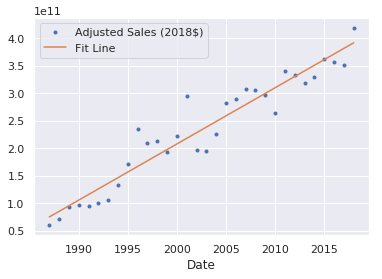

In [45]:
semiconductors = pd.read_csv("semiconductor.csv")
semiconductors["Date"] = pd.to_datetime(semiconductors['Date'] + 1, format="%Y")

# adjust for inflation, convert to USD
semiconductors = pd.merge_asof(
    semiconductors,
    cpi.filter(items=['Date', 'Price Multiplier']),
    on='Date',
    direction='nearest')
semiconductors['Adjusted Sales (2018$)'] = semiconductors['Sales (Thousands of USD)'] * semiconductors['Price Multiplier'] * 1000

# unix time
time = semiconductors['Date'].astype(np.int64) / 10**9
y = semiconductors['Adjusted Sales (2018$)']

# linear regression
slope, intercept = np.polyfit(time, y, 1)
semiconductors['Fit Line'] = pd.Series(intercept + slope * time)

semiconductors.plot(x='Date',
                    y=['Adjusted Sales (2018$)', 'Fit Line'],
                    style=['.', '-'])

print('r = {:.3f}'.format(
    semiconductors['Adjusted Sales (2018$)'].corr(
        semiconductors['Fit Line'])))
print("Years to reach one trillion USD: {:.2f}".format(
    (1e12 - intercept) / slope / (3600*24*365)))

Also worth noting is that both the [Apollo Program](https://en.wikipedia.org/wiki/Apollo_program) and the [Manhattan Project](https://en.wikipedia.org/wiki/Manhattan_Project) each cost just under half of one percent 
[Gross World Product](http://holtz.org/Library/Social%20Science/Economics/Estimating%20World%20GDP%20by%20DeLong/Estimating%20World%20GDP.htm), and were regarded as hugely expensive and unsustainable efforts. 

In [46]:
projects = pd.DataFrame(data={"Project":["Manhattan Project",
                                         "Apollo Program"],
                              "Cost":[2e9, 25.4e9],
                              "Date":["1940-01-01", "1973-01-01"],
                              "GWP (1990$)":[4502584e6, 16022888e6]})

projects['Date'] = pd.to_datetime(projects['Date'],
                                  infer_datetime_format=True)
projects = pd.merge_asof(projects,
                         cpi.filter(items=['Date', 'Price Multiplier']),
                         on='Date',
                         direction='nearest')

projects['Cost'] = projects['Cost'] * projects['Price Multiplier']
projects['GWP (2018$)'] = (projects['GWP (1990$)'] *
                           float(cpi[cpi['Date'] == 
                                     '1990-01-01']['Price Multiplier']))

projects['Percent of GWP'] = projects['Cost'] / projects['GWP (2018$)'] * 100
projects[['Project', 'Percent of GWP']]

,Project,Percent of GWP
0,Manhattan Project,0.407120
1,Apollo Program,0.474081


Gross World Product is currently estimated to be around \$80 trillion and [projected](https://data.oecd.org/gdp/gdp-long-term-forecast.htm) to be \$38 trillion in 2060. Taking these numbers as a guide, it seems unlikely that expenditures would exceed \\$1 trillion before the late 21st century, and in all likelihood not even that.

,Percentile,AGI Budget (2018$)
0,1,1.047156e+10
1,5,1.266899e+10
2,25,3.209692e+10
3,50,1.006332e+11
4,75,3.202036e+11
5,95,7.982820e+11
6,99,9.526886e+11


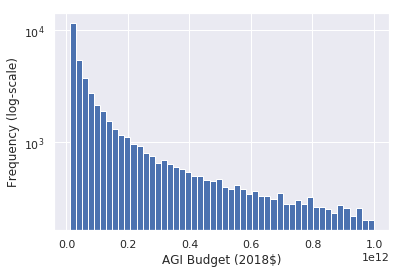

In [47]:
#budget = lognorm.rvs(s=1, scale=1e11, size=n)
budget = loguniform(low=10, high=12, size=n)
plt.hist(budget, bins=50, log=True);
plt.xlabel("AGI Budget (2018$)");
plt.ylabel("Frequency (log-scale)");
summary(budget, 'AGI Budget (2018$)')

### Hardware Price-Performance
At the time of this writing, a TPU performing 180 FLOPS can be rented at the rate of [4.5 USD per hour](https://cloud.google.com/tpu/docs/pricing).

In [48]:
# Cost per hour of TPU
tpu_cost = 4.5
# Computational performance of TPU
tpu_compute = 180e12
# Current price-performance of ML hardware
price_performance = tpu_compute * 3600 / tpu_cost

### Number of Doublings Required

We can now calculate the number of doublings in price-performance required to train an AGI given our budgetary constraints.

,Percentile,Doublings
0,1,6.612339
1,5,15.637536
2,25,37.673011
3,50,64.201534
4,75,91.083337
5,95,113.442426
6,99,121.385305


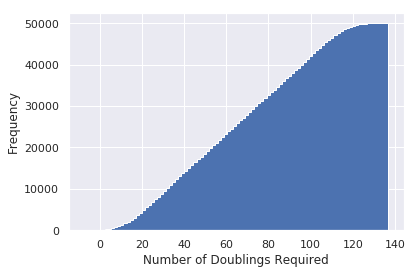

In [49]:
# Required cost efficiency of ML hardware
required_performance = agi_compute / budget
# Number of doublings required for AGI to be economically feasible
doublings_required = np.log2(required_performance 
                             / (price_performance * tpu_improvement))
plt.hist(doublings_required,
         bins=100,
         histtype="stepfilled",
         cumulative=True);
plt.xlabel("Number of Doublings Required");
plt.ylabel("Frequency");
#plt.savefig("doublings.pdf")
summary(doublings_required, 'Doublings')

## Projected Timeline
As was noted above, there is not currently an obvious path to exponential improvements in price-performance after ~10-12 further doublings. The conclusion seems to be that this approach is simply not viable, but if we assume that these trends (somehow) continue, we can estimate the timeline.

,Percentile,Years
0,1,25.982804
1,5,61.446788
2,25,148.033909
3,50,252.276198
4,75,357.906678
5,95,445.765419
6,99,476.976503


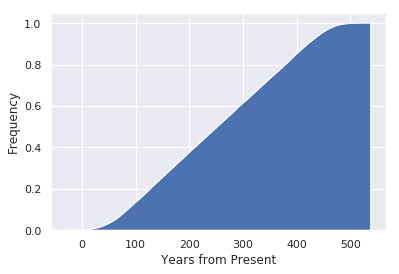

In [50]:
timeline = doublings_required * doubling_time
plt.hist(timeline,
         bins=1000,
         cumulative=True,
         histtype="stepfilled",
         density=True);
plt.xlabel("Years from Present");
plt.ylabel("Frequency");
#plt.savefig("timeline.pdf")
summary(timeline, 'Years')